# PROBLEM STATEMENT

Here, we generate data from the following linear and Gaussian state-space model:
\begin{align}
  x(t) & = 0.95 x(t-1) + \eta(t)\\
  y(t) & = x(t) + \epsilon(t)
\end{align}
with $\eta(t) \sim \mathcal{N}\left(0,Q=1\right)$ and $\epsilon(t) \sim \mathcal{N}\left(0,R=1\right)$. The idea is to evaluate the impact of bad $Q$ and $R$ error variances on the quality of the reconstructed state using the linear Kalman smoother.

# CAUTION

The KalmanFilter library returns an array for $x^s$ that need to be transformed using ravel()...

# IMPORT MODULES

Here, we import the different Python libraries and modules. Concerning the dynamical models, we provide two different implementations: a slow procedure in Python and a fast procedure in Fortran. In order to use the Fortran version, you need to compile the f90 files in the "models" folder ("l63_for.f90" and "l96_for.f90") using the command "f2py". You also need to download the "tqdm" library to display the progress bar (available at http://github.com/tqdm/).

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# Kalman filter and smoother (linear case)
from pykalman import KalmanFilter

# data assimilation routines
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# GENERATE DATA

Here, we generate true state following a AR(1) dynamical equation and we generate noisy observations.

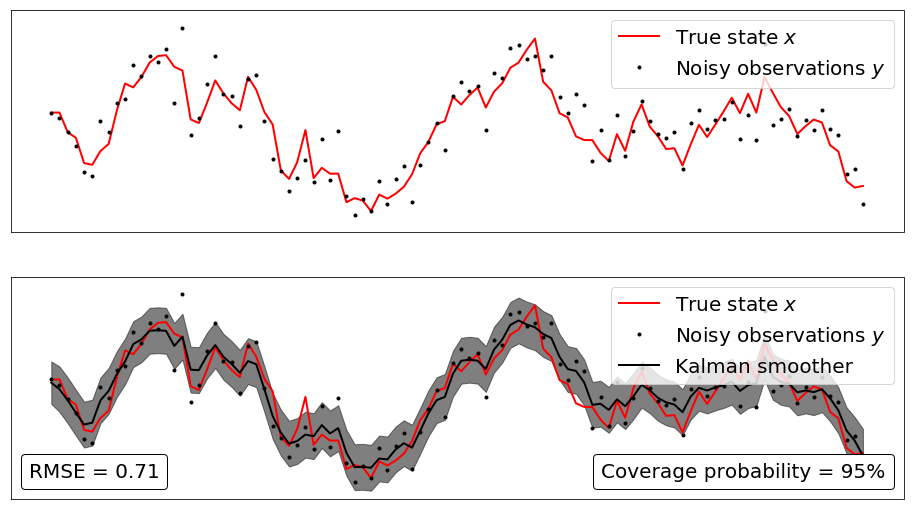

In [2]:
# random number generator
numpy.random.seed(9)

# generate true state and noisy observations
Nx=1
No=1
Q_true=eye(Nx)
R_true=eye(No)
T=100
X_true=zeros(T)
Yo=zeros(T)
for t in range(T):
    if t>0:
        X_true[t]=0.95*X_true[t-1]+random.normal(0,Q_true)
        Yo[t]=X_true[t]+random.normal(0,R_true)

# apply Kalman smoother with good covariances
kf_true_Q_R = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = R_true)
Xs_true_Q_R, Ps_true_Q_R = kf_true_Q_R.smooth(Yo)

# plot
figure()
subplot(2,1,1)
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
ylim(min(Yo)-1,max(Yo)+1)
xticks([]);yticks([])
legend([line1, line2], ['True state $x$', 'Noisy observations $y$'], prop={'size': 20})
#title('True state $x$ (red) and noisy observations $y$ (dark)',fontsize=20)

ax0=subplot(2,1,2)
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_true_Q_R,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)),
                        squeeze(Xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_true_Q_R)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax0.add_artist(at)
at=AnchoredText('Coverage probability = 95%',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax0.add_artist(at)
xticks([]);yticks([])
legend([line1, line2, line3], ['True state $x$', 'Noisy observations $y$', 'Kalman smoother'], prop={'size': 20})
#title('$Q=Q^t \ & \ R=R^t$', fontsize=20)
#title('Smoothing with $Q=Q^t$ and $R=R^t$', fontsize=20)

# APPLY KALMAN WITH BAD COVARIANCES

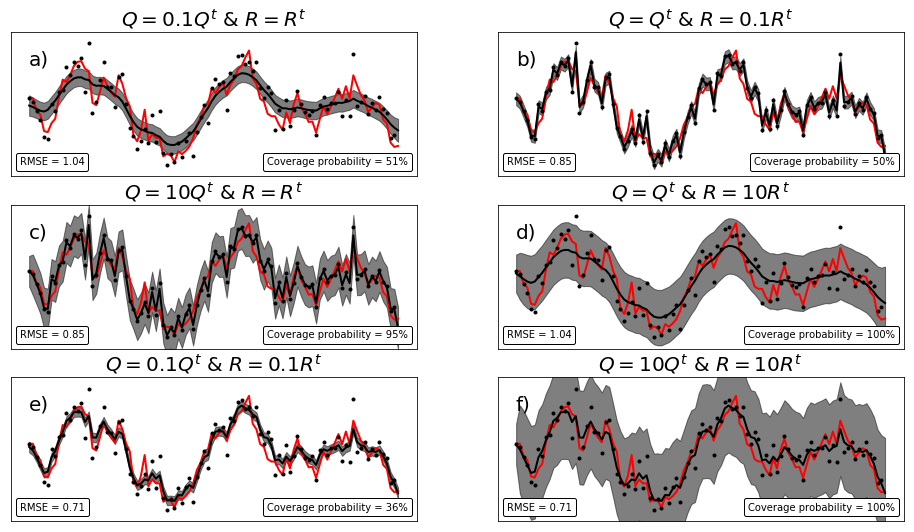

In [3]:
# apply Kalman smoother with bad covariances (underestimation)
kf_Q_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 0.1*Q_true, observation_covariance = R_true)
kf_R_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = 0.1*R_true)
kf_Q_R_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 0.1*Q_true, observation_covariance = 0.1*R_true)
Xs_Q_underest, Ps_Q_underest = kf_Q_underest.smooth(Yo)
Xs_R_underest, Ps_R_underest = kf_R_underest.smooth(Yo)
Xs_Q_R_underest, Ps_Q_R_underest = kf_Q_R_underest.smooth(Yo)

# apply Kalman smoother with bad covariances (overestimation)
kf_Q_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 10*Q_true, observation_covariance = R_true)
kf_R_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = 10*R_true)
kf_Q_R_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 10*Q_true, observation_covariance = 10*R_true)
Xs_Q_overest, Ps_Q_overest = kf_Q_overest.smooth(Yo)
Xs_R_overest, Ps_R_overest = kf_R_overest.smooth(Yo)
Xs_Q_R_overest, Ps_Q_R_overest = kf_Q_R_overest.smooth(Yo)

# apply Kalman smoother with good covariances
kf_true_Q_R = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = R_true)
Xs_true_Q_R, Ps_true_Q_R = kf_true_Q_R.smooth(Yo)

# number of observations in the 95% confidence intervals
nb_Q_underest = sum((squeeze(Xs_Q_underest) - 1.96 * sqrt(squeeze(Ps_Q_underest)) <= X_true) & \
          (squeeze(Xs_Q_underest) + 1.96 * sqrt(squeeze(Ps_Q_underest)) >= X_true)) / T
nb_R_underest = sum((squeeze(Xs_R_underest) - 1.96 * sqrt(squeeze(Ps_R_underest)) <= X_true) & \
          (squeeze(Xs_R_underest) + 1.96 * sqrt(squeeze(Ps_R_underest)) >= X_true)) / T
nb_Q_overest = sum((squeeze(Xs_Q_overest) - 1.96 * sqrt(squeeze(Ps_Q_overest)) <= X_true) & \
          (squeeze(Xs_Q_overest) + 1.96 * sqrt(squeeze(Ps_Q_overest)) >= X_true)) / T
nb_R_overest = sum((squeeze(Xs_R_overest) - 1.96 * sqrt(squeeze(Ps_R_overest)) <= X_true) & \
          (squeeze(Xs_R_overest) + 1.96 * sqrt(squeeze(Ps_R_overest)) >= X_true)) / T
nb_Q_R_underest = sum((squeeze(Xs_Q_R_underest) - 1.96 * sqrt(squeeze(Ps_Q_R_underest)) <= X_true) & \
          (squeeze(Xs_Q_R_underest) + 1.96 * sqrt(squeeze(Ps_Q_R_underest)) >= X_true)) / T
nb_Q_R_overest = sum((squeeze(Xs_Q_R_overest) - 1.96 * sqrt(squeeze(Ps_Q_R_overest)) <= X_true) & \
          (squeeze(Xs_Q_R_overest) + 1.96 * sqrt(squeeze(Ps_Q_R_overest)) >= X_true)) / T
#print(sum((squeeze(Xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)) <= X_true) & \
#          (squeeze(Xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)) >= X_true)) / T)

figure()
ax1=subplot(3,2,1);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_underest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_underest) - 1.96 * sqrt(squeeze(Ps_Q_underest)),
                        squeeze(Xs_Q_underest) + 1.96 * sqrt(squeeze(Ps_Q_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('a)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_Q_underest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_Q_underest*100)) + '%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
xticks([]);yticks([])
title('$Q=0.1Q^t \ & \ R=R^t$', fontsize=20)

ax2=subplot(3,2,2);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_R_underest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_R_underest) - 1.96 * sqrt(squeeze(Ps_R_underest)),
                        squeeze(Xs_R_underest) + 1.96 * sqrt(squeeze(Ps_R_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('b)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_R_underest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_R_underest*100))+ '%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
xticks([]);yticks([])
title('$Q=Q^t \ & \ R=0.1R^t$', fontsize=20)

ax3=subplot(3,2,3);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_overest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_overest) - 1.96 * sqrt(squeeze(Ps_Q_overest)),
                        squeeze(Xs_Q_overest) + 1.96 * sqrt(squeeze(Ps_Q_overest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('c)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_Q_overest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_Q_overest*100)) +'%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
xticks([]);yticks([])
title('$Q=10Q^t \ & \ R=R^t$', fontsize=20)

ax4=subplot(3,2,4);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_R_overest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_R_overest) - 1.96 * sqrt(squeeze(Ps_R_overest)),
                        squeeze(Xs_R_overest) + 1.96 * sqrt(squeeze(Ps_R_overest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('d)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_R_overest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_R_overest*100))+'%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)
xticks([]);yticks([])
title('$Q=Q^t \ & \ R=10R^t$', fontsize=20)

ax5=subplot(3,2,5);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_R_underest,'k',linewidth=2)
#line4,=plot(range(T),Xs_true_Q_R,'--g',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_R_underest) - 1.96 * sqrt(squeeze(Ps_Q_R_underest)),
                        squeeze(Xs_Q_R_underest) + 1.96 * sqrt(squeeze(Ps_Q_R_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('e)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_Q_R_underest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_Q_R_underest*100))+'%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
xticks([]);yticks([])
title('$Q=0.1Q^t \ & \ R=0.1R^t$', fontsize=20)

ax6=subplot(3,2,6);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_R_overest,'k',linewidth=2)
#line4,=plot(range(T),Xs_true_Q_R,'--g',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_R_overest) - 1.96 * sqrt(squeeze(Ps_Q_R_overest)),
                        squeeze(Xs_Q_R_overest) + 1.96 * sqrt(squeeze(Ps_Q_R_overest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('f)',
                prop=dict(size=20), frameon=False,
                loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)
at=AnchoredText('RMSE = '+str(round(RMSE(ravel(Xs_Q_R_overest)-X_true),2)),
                prop=dict(size=10), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)
at=AnchoredText('Coverage probability = '+ str(int(nb_Q_R_overest*100)) +'%',
                prop=dict(size=10), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)
xticks([]);yticks([])
title('$Q=10Q^t \ & \ R=10R^t$', fontsize=20)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp_Q_R_AR1.png', bbox_inches='tight')#, pad_inches=0)

# EVALUATE IMPACT OF COVARIANCES, RMSE, 95%CI, LIKELIHOOD

In [4]:
# vary values of covariances and compute RMSE, likelihood, pourcentage of true state in the 95% CI
n_var=20
tab_RMSE = zeros([n_var, n_var])
tab_95CI = zeros([n_var, n_var])
tab_loglik = zeros([n_var, n_var])
variations_Q = linspace(0.1, 2, n_var)
variations_R = linspace(0.1, 2, n_var)
for i_Q in range(n_var):
    for i_R in range(n_var):
        kf_varying_Q_R = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                          initial_state_mean = [[0]], initial_state_covariance = [[1]],
                          transition_covariance = variations_Q[i_Q]*Q_true,
                          observation_covariance = variations_R[i_R]*R_true)
        Xs_varying_Q_R, Ps_varying_Q_R = kf_varying_Q_R.smooth(Yo)
        tab_RMSE[i_Q,i_R] = RMSE(X_true-ravel(Xs_varying_Q_R))
        nb_varying_Q_R = sum((squeeze(Xs_varying_Q_R) - 1.96 * sqrt(squeeze(Ps_varying_Q_R)) <= X_true) & \
                             (squeeze(Xs_varying_Q_R) + 1.96 * sqrt(squeeze(Ps_varying_Q_R)) >= X_true)) / T
        tab_95CI[i_Q,i_R] = nb_varying_Q_R
        tab_loglik[i_Q,i_R] = kf_varying_Q_R.loglikelihood(Yo)

Text(0,0.5,'Log-likelihood')

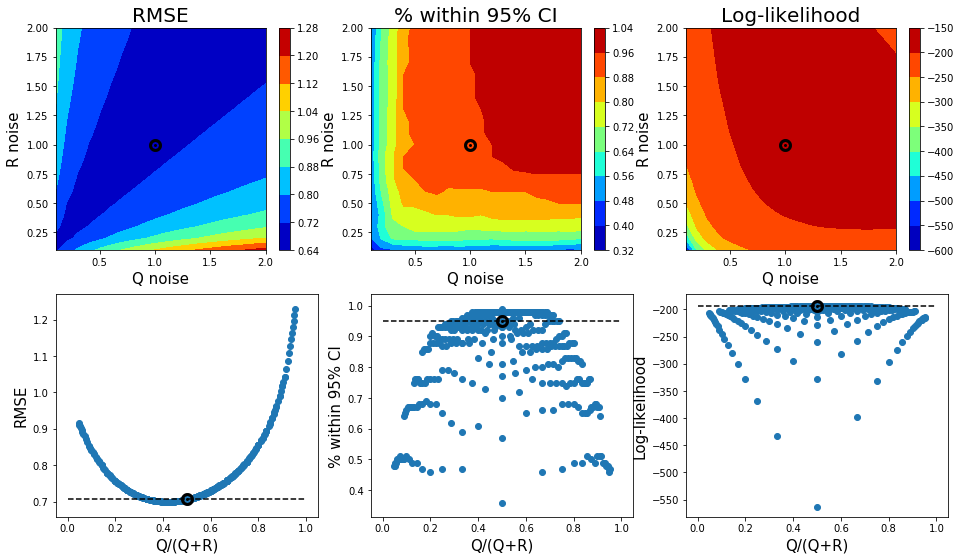

In [5]:
# plot
VARIATIONS_Q, VARIATIONS_R = meshgrid(variations_Q, variations_R)

subplot(2,3,1)
contourf(VARIATIONS_Q, VARIATIONS_R, tab_RMSE, cmap='jet')
colorbar()
scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Q noise', fontsize=15)
ylabel('R noise', fontsize=15)
title('RMSE', fontsize=20)

subplot(2,3,2)
contourf(VARIATIONS_Q, VARIATIONS_R, tab_95CI, cmap='jet')
colorbar()
scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Q noise', fontsize=15)
ylabel('R noise', fontsize=15)
title('% within 95% CI', fontsize=20)

subplot(2,3,3)
contourf(VARIATIONS_Q, VARIATIONS_R, tab_loglik, cmap='jet')
colorbar()
scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Q noise', fontsize=15)
ylabel('R noise', fontsize=15)
title('Log-likelihood', fontsize=20)

subplot(2,3,4)
scatter(ravel(VARIATIONS_Q/(VARIATIONS_Q+VARIATIONS_R)), ravel(tab_RMSE))
plot([0, 1], [RMSE(X_true-ravel(Xs_true_Q_R)), RMSE(X_true-ravel(Xs_true_Q_R))], '--k')
scatter(Q_true/(Q_true+R_true), RMSE(X_true-ravel(Xs_true_Q_R)), marker='.', linewidths=10, c='k')
xlabel('Q/(Q+R)', fontsize=15)
ylabel('RMSE', fontsize=15)

subplot(2,3,5)
scatter(ravel(VARIATIONS_Q/(VARIATIONS_Q+VARIATIONS_R)), ravel(tab_95CI))
plot([0, 1], [0.95, 0.95], '--k')
scatter(Q_true/(Q_true+R_true), 0.95, marker='.', linewidths=10, c='k')
xlabel('Q/(Q+R)', fontsize=15)
ylabel('% within 95% CI', fontsize=15)

subplot(2,3,6)
scatter(ravel(VARIATIONS_Q/(VARIATIONS_Q+VARIATIONS_R)), ravel(tab_loglik))
plot([0, 1], [kf_true_Q_R.loglikelihood(Yo), kf_true_Q_R.loglikelihood(Yo)], '--k')
scatter(Q_true/(Q_true+R_true), kf_true_Q_R.loglikelihood(Yo), marker='.', linewidths=10, c='k')
xlabel('Q/(Q+R)', fontsize=15)
ylabel('Log-likelihood', fontsize=15)

# EVALUATE RELATIONSHIPS BETWEEN Q AND R

In [6]:
# random number generator
numpy.random.seed(5)

# generate y and x (with large T)
T_large = 1000
n_iter_em = 5

X_true_large=zeros(T_large)
Yo_large=zeros(T_large)
for t in range(T_large):
    if t>0:
        X_true_large[t]=0.95*X_true_large[t-1]+random.normal(0,Q_true)
        Yo_large[t]=X_true_large[t]+random.normal(0,R_true)

# fix value of Q (and R) and respectively estimate R (and Q) with EM
n_var = 50
tab_estimate_Q = zeros([n_var])
tab_estimate_Q_loglik = zeros([n_var])
tab_estimate_Q_RMSE = zeros([n_var])
tab_estimate_Q_CP = zeros([n_var])
tab_estimate_R = zeros([n_var])
tab_estimate_R_loglik = zeros([n_var])
tab_estimate_R_RMSE = zeros([n_var])
tab_estimate_R_CP = zeros([n_var])
fix_Q = linspace(0.25, 2, n_var)
fix_R = linspace(0.25, 2, n_var)

for i_Q in range(n_var):
    kf_fix_Q_estimate_R = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],\
                                       initial_state_mean = [[0]], initial_state_covariance = [[1]],\
                                       transition_covariance = fix_Q[i_Q]*Q_true,\
                                       observation_covariance = R_true)
    kf_fix_Q_estimate_R.em(Yo_large, n_iter=n_iter_em, em_vars=['observation_covariance'])
    tab_estimate_R[i_Q] = kf_fix_Q_estimate_R.observation_covariance
    tab_estimate_R_loglik[i_Q] = kf_fix_Q_estimate_R.loglikelihood(Yo_large)
    Xs_fix_Q_estimate_R, Ps_fix_Q_estimate_R = kf_fix_Q_estimate_R.smooth(Yo_large)
    tab_estimate_R_RMSE[i_Q] = RMSE(X_true_large-ravel(Xs_fix_Q_estimate_R))
    tab_estimate_R_CP[i_Q] = 100*sum((squeeze(Xs_fix_Q_estimate_R) - 1.96 * sqrt(squeeze(Ps_fix_Q_estimate_R)) <= X_true_large) & \
                                     (squeeze(Xs_fix_Q_estimate_R) + 1.96 * sqrt(squeeze(Ps_fix_Q_estimate_R)) >= X_true_large)) / T_large

for i_R in range(n_var):
    kf_fix_R_estimate_Q = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],\
                                       initial_state_mean = [[0]], initial_state_covariance = [[1]],\
                                       transition_covariance = Q_true,\
                                       observation_covariance = fix_R[i_R]*R_true)
    kf_fix_R_estimate_Q.em(Yo_large, n_iter=n_iter_em, em_vars=['transition_covariance'])
    tab_estimate_Q[i_R] = kf_fix_R_estimate_Q.transition_covariance
    tab_estimate_Q_loglik[i_R] = kf_fix_R_estimate_Q.loglikelihood(Yo_large)
    Xs_fix_R_estimate_Q, Ps_fix_R_estimate_Q = kf_fix_R_estimate_Q.smooth(Yo_large)
    tab_estimate_Q_RMSE[i_R] = RMSE(X_true_large-ravel(Xs_fix_R_estimate_Q))
    tab_estimate_Q_CP[i_R] = 100*sum((squeeze(Xs_fix_R_estimate_Q) - 1.96 * sqrt(squeeze(Ps_fix_R_estimate_Q)) <= X_true_large) & \
                                     (squeeze(Xs_fix_R_estimate_Q) + 1.96 * sqrt(squeeze(Ps_fix_R_estimate_Q)) >= X_true_large)) / T_large

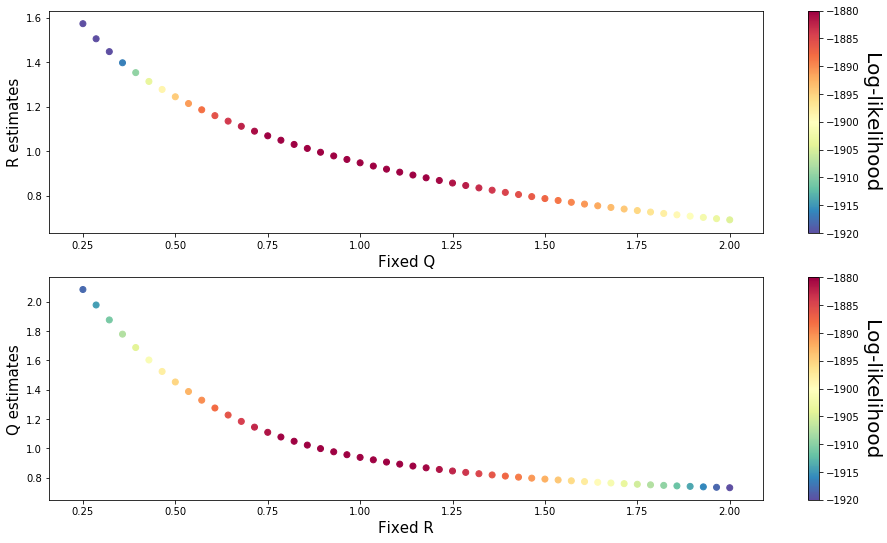

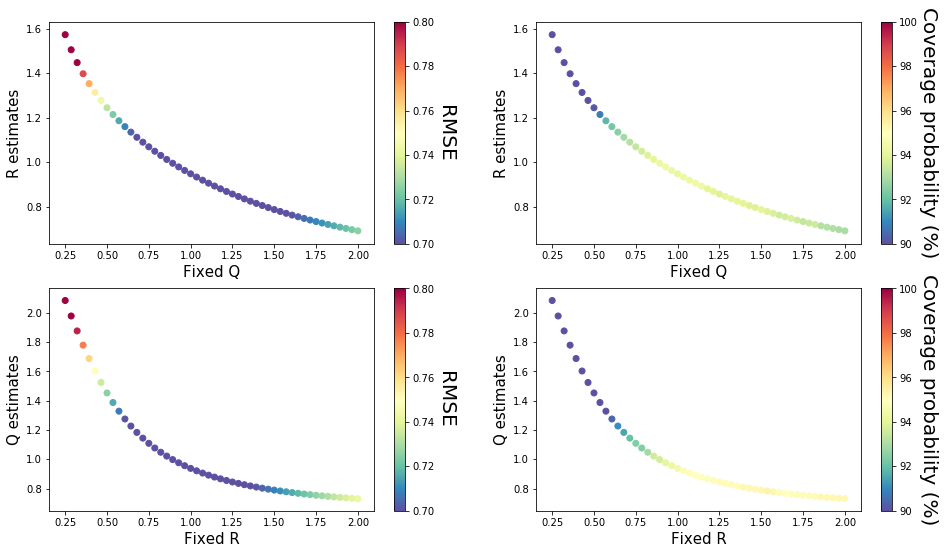

In [7]:
# plot log likelihood
figure()
subplot(2,1,1)
scatter(fix_Q, tab_estimate_R, c=tab_estimate_R_loglik, cmap='Spectral_r')
#plot([ravel(R_true), ravel(R_true)], [min(tab_estimate_R), max(tab_estimate_R)], '--k')
#plot([min(fix_Q), max(fix_Q)], [ravel(Q_true), ravel(Q_true)], '--k')
clim([-1920, -1880])
cbar = colorbar()
cbar.set_label('Log-likelihood', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed Q', fontsize=15)
ylabel('R estimates', fontsize=15)
subplot(2,1,2)
scatter(fix_R, tab_estimate_Q, c=tab_estimate_Q_loglik, cmap='Spectral_r')
#plot([ravel(Q_true), ravel(Q_true)], [min(tab_estimate_Q), max(tab_estimate_Q)], '--k')
#plot([min(fix_R), max(fix_R)], [ravel(R_true), ravel(R_true)], '--k')
clim([-1920, -1880])
cbar = colorbar()
cbar.set_label('Log-likelihood', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed R', fontsize=15)
ylabel('Q estimates', fontsize=15)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp_compensate_Q_R_AR1.png', bbox_inches='tight')#, pad_inches=0)

# plot RMSE and coverage probability
figure()
subplot(2,2,1)
scatter(fix_Q, tab_estimate_R, c=tab_estimate_R_RMSE, cmap='Spectral_r')
#plot([ravel(R_true), ravel(R_true)], [min(tab_estimate_R), max(tab_estimate_R)], '--k')
#plot([min(fix_Q), max(fix_Q)], [ravel(Q_true), ravel(Q_true)], '--k')
clim([0.7, 0.8])
cbar = colorbar()
cbar.set_label('RMSE', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed Q', fontsize=15)
ylabel('R estimates', fontsize=15)

subplot(2,2,2)
scatter(fix_Q, tab_estimate_R, c=tab_estimate_R_CP, cmap='Spectral_r')
#plot([ravel(R_true), ravel(R_true)], [min(tab_estimate_R), max(tab_estimate_R)], '--k')
#plot([min(fix_Q), max(fix_Q)], [ravel(Q_true), ravel(Q_true)], '--k')
clim([90, 100])
cbar = colorbar()
cbar.set_label('Coverage probability (%)', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed Q', fontsize=15)
ylabel('R estimates', fontsize=15)

subplot(2,2,3)
scatter(fix_R, tab_estimate_Q, c=tab_estimate_Q_RMSE, cmap='Spectral_r')
#plot([ravel(Q_true), ravel(Q_true)], [min(tab_estimate_Q), max(tab_estimate_Q)], '--k')
#plot([min(fix_R), max(fix_R)], [ravel(R_true), ravel(R_true)], '--k')
clim([0.7, 0.8])
cbar = colorbar()
cbar.set_label('RMSE', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed R', fontsize=15)
ylabel('Q estimates', fontsize=15)

subplot(2,2,4)
scatter(fix_R, tab_estimate_Q, c=tab_estimate_Q_CP, cmap='Spectral_r')
#plot([ravel(Q_true), ravel(Q_true)], [min(tab_estimate_Q), max(tab_estimate_Q)], '--k')
#plot([min(fix_R), max(fix_R)], [ravel(R_true), ravel(R_true)], '--k')
clim([90, 100])
cbar = colorbar()
cbar.set_label('Coverage probability (%)', rotation=270, fontsize = 20, labelpad=+20)
#scatter(Q_true, R_true, marker='.', linewidths=10, c='k')
xlabel('Fixed R', fontsize=15)
ylabel('Q estimates', fontsize=15)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp_compensate_Q_R_AR1_RMSE_CP.png', bbox_inches='tight')#, pad_inches=0)